In [53]:
%pip install pandas matplotlib seaborn scipy statsmodels

Note: you may need to restart the kernel to use updated packages.


# Projeto Probest - Parte 1: Análise Exploratória (EDA)

Iniciando a Etapa 1 do projeto: Análise Exploratória de Dados (EDA).

In [36]:
import pandas as pd
import numpy as np

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.options.display.float_format = '{:.6f}'.format

## 1. Carregamento dos Dados

Carregando o arquivo `ndt_tests_corrigido.csv` e verificando sua estrutura.

In [37]:
file_path = 'ndt_tests_corrigido.csv'

try:
    df = pd.read_csv(file_path)
    print(f"Dataset carregado: {file_path}")
    print(f"Formato: {df.shape}")
    
    print("\nColunas disponíveis:")
    print(df.columns.tolist())
    
    print("\nVerificando dados (primeiras linhas):")
    print(df.head())
    
except FileNotFoundError:
    print(f"ERRO: Arquivo não encontrado em '{file_path}'")
except Exception as e:
    print(f"Ocorreu um erro: {e}")

Dataset carregado: ndt_tests_corrigido.csv
Formato: (7087, 8)

Colunas disponíveis:
['timestamp', 'download_throughput_bps', 'rtt_download_sec', 'upload_throughput_bps', 'rtt_upload_sec', 'packet_loss_percent', 'client', 'server']

Verificando dados (primeiras linhas):
                       timestamp  download_throughput_bps  rtt_download_sec  upload_throughput_bps  rtt_upload_sec  packet_loss_percent    client    server
0  2025-08-09 15:28:02.000 +0000          82236567.995454          0.231862        69732172.059986        0.247727             0.000000  client12  server06
1  2025-08-09 15:30:11.000 +0000         902731479.238230          0.012000       852177960.399178        0.005423             0.008226  client01  server07
2  2025-08-10 04:27:43.000 +0000         591065502.098614          0.014000       281218794.113733        0.014544             5.954284  client13  server07
3  2025-08-09 22:45:07.000 +0000         672113910.536765          0.011000       113539960.296302        

## 2. Pré-processamento: Normalização

A coluna `packet_loss_percent` está em formato percentual (0-100). Para a modelagem (especialmente Beta-Binomial), precisamos dela como uma fração (0-1). Vamos criar uma nova coluna `packet_loss_fraction`.

In [38]:
# Criar a coluna de fração de perda dividindo por 100
if 'packet_loss_percent' in df.columns:
    df['packet_loss_fraction'] = df['packet_loss_percent'] / 100
    print("Coluna 'packet_loss_fraction' criada.")
    
    # Verificar a nova coluna
    print(df[['packet_loss_percent', 'packet_loss_fraction']].head())
else:
    print("AVISO: Coluna 'packet_loss_percent' não encontrada.")

Coluna 'packet_loss_fraction' criada.
   packet_loss_percent  packet_loss_fraction
0             0.000000              0.000000
1             0.008226              0.000082
2             5.954284              0.059543
3             0.261528              0.002615
4             1.381646              0.013816


## 3. Definição das Estatísticas e Variáveis

Definindo as variáveis de interesse (com os nomes corretos do CSV) e as funções de agregação.

[cite_start]Conforme solicitado no PDF[cite: 21, 22], incluímos os quantis 0.9 e 0.99. A justificativa para essa escolha é que, em análise de desempenho de rede, os piores cenários (a "cauda" da distribuição) são mais importantes que a média. [cite_start]Queremos observar o comportamento para os 10% (q_0.9) e 1% (q_0.99) piores casos, especialmente para RTT e perda de pacotes.

In [39]:
variables_to_analyze = [
    'download_throughput_bps',
    'upload_throughput_bps',
    'rtt_download_sec',
    'rtt_upload_sec',
    'packet_loss_fraction'
]

group_by_client_col = 'client'
group_by_server_col = 'server'

def q_0_9(x):
    return x.quantile(0.9)

def q_0_99(x):
    return x.quantile(0.99)

stats_to_calculate = ['mean', 'median', 'var', 'std', q_0_9, q_0_99]

print("Variáveis e estatísticas (corrigidas) definidas.")

Variáveis e estatísticas (corrigidas) definidas.


## 4. Análise Agrupada por Cliente

Cálculo das estatísticas descritivas para cada variável, agrupadas por `client`.

In [40]:
try:
    stats_by_client = df.groupby(group_by_client_col)[variables_to_analyze].agg(stats_to_calculate)
    
    stats_by_client.rename(columns={'std': 'std_dev'}, level=1, inplace=True)

    print("--- Estatísticas por Cliente ---")
    print(stats_by_client)

except KeyError as e:
    print(f"ERRO: Chave não encontrada. Verifique os nomes das colunas. Detalhe: {e}")
except Exception as e:
    print(f"Ocorreu um erro: {e}")

--- Estatísticas por Cliente ---
         download_throughput_bps                                                                                               upload_throughput_bps                                                                                               rtt_download_sec                                              rtt_upload_sec                                              packet_loss_fraction                                             
                            mean           median                       var          std_dev            q_0_9           q_0_99                  mean           median                       var          std_dev            q_0_9           q_0_99             mean   median      var  std_dev    q_0_9   q_0_99           mean   median      var  std_dev    q_0_9   q_0_99                 mean   median      var  std_dev    q_0_9   q_0_99
client                                                                                                   

## 5. Análise Agrupada por Servidor

Cálculo das estatísticas descritivas para cada variável, agrupadas por `server`.

In [41]:
try:
    stats_by_server = df.groupby(group_by_server_col)[variables_to_analyze].agg(stats_to_calculate)
    
    stats_by_server.rename(columns={'std': 'std_dev'}, level=1, inplace=True)

    print("--- Estatísticas por Servidor ---")
    print(stats_by_server)

except KeyError as e:
    print(f"ERRO: Chave não encontrada. Verifique os nomes das colunas. Detalhe: {e}")
except Exception as e:
    print(f"Ocorreu um erro: {e}")

--- Estatísticas por Servidor ---
         download_throughput_bps                                                                                               upload_throughput_bps                                                                                               rtt_download_sec                                              rtt_upload_sec                                              packet_loss_fraction                                             
                            mean           median                       var          std_dev            q_0_9           q_0_99                  mean           median                       var          std_dev            q_0_9           q_0_99             mean   median      var  std_dev    q_0_9   q_0_99           mean   median      var  std_dev    q_0_9   q_0_99                 mean   median      var  std_dev    q_0_9   q_0_99
server                                                                                                  

# Etapa 2: Análise Gráfica e Seleção

Com base nas tabelas da Etapa 1, selecionamos duas entidades com comportamentos distintos para a análise: `client12` e `client13`.

* **client12**: RTT alto (lento), mas perda de pacotes quase zero (confiável).
* **client13**: RTT baixo (rápido), mas a maior perda de pacotes (não confiável).

Vamos filtrar o dataframe e importar as bibliotecas de visualização.

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

selected_entities = ['client12', 'client13']
entity_column = 'client'

df_selected = df[df[entity_column].isin(selected_entities)].copy()

print(f"DataFrame filtrado para as entidades: {selected_entities}")
print(df_selected.shape)

DataFrame filtrado para as entidades: ['client12', 'client13']
(1284, 9)


## 2.1 Histogramas (Distribuição)

Vamos plotar os histogramas para as 5 variáveis de interesse, comparando os dois clientes. Isso nos ajudará a ver a forma da distribuição de cada variável.

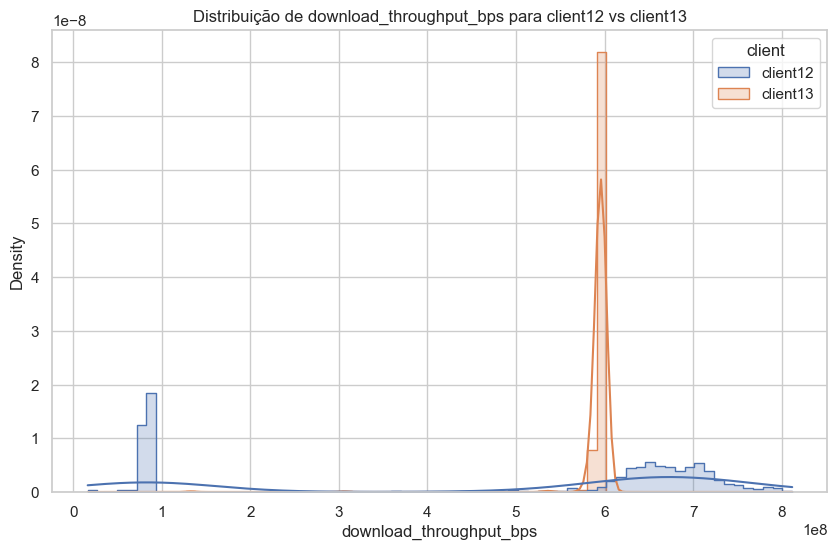

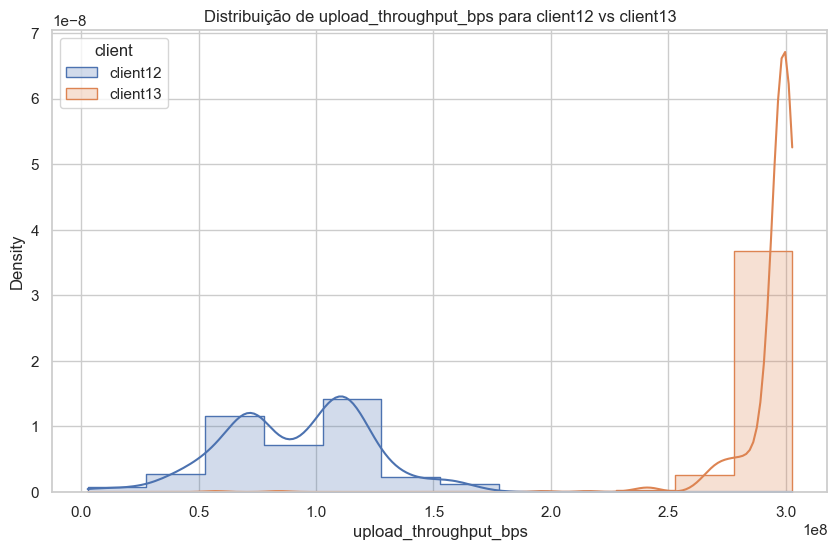

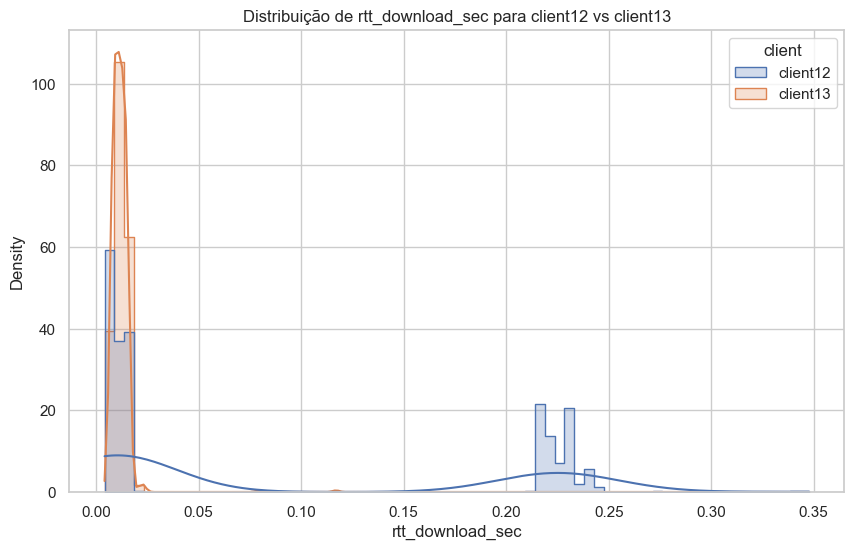

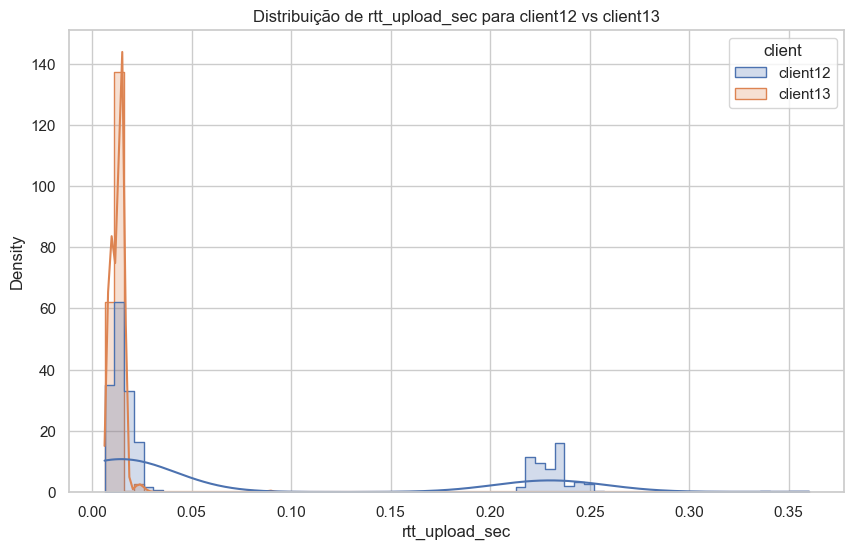

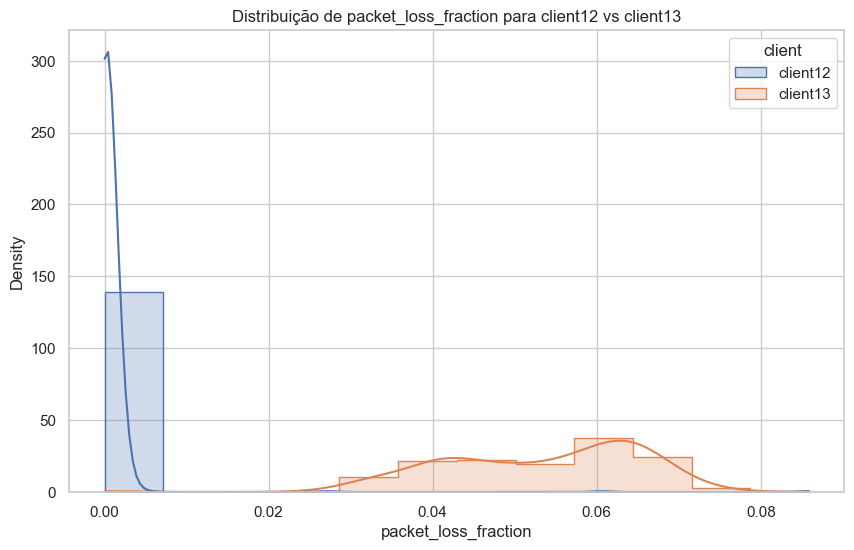

In [26]:
sns.set_theme(style="whitegrid")

for var in variables_to_analyze:
    plt.figure(figsize=(10, 6))
    sns.histplot(
        data=df_selected,
        x=var,
        hue=entity_column,
        kde=True,
        element="step",
        stat="density",
        common_norm=False
    )
    plt.title(f'Distribuição de {var} para {selected_entities[0]} vs {selected_entities[1]}')
    plt.show()

## 2.2 Boxplots (Outliers e Quartis)

Os boxplots são úteis para comparar os quartis e identificar visualmente a presença de outliers em cada variável.

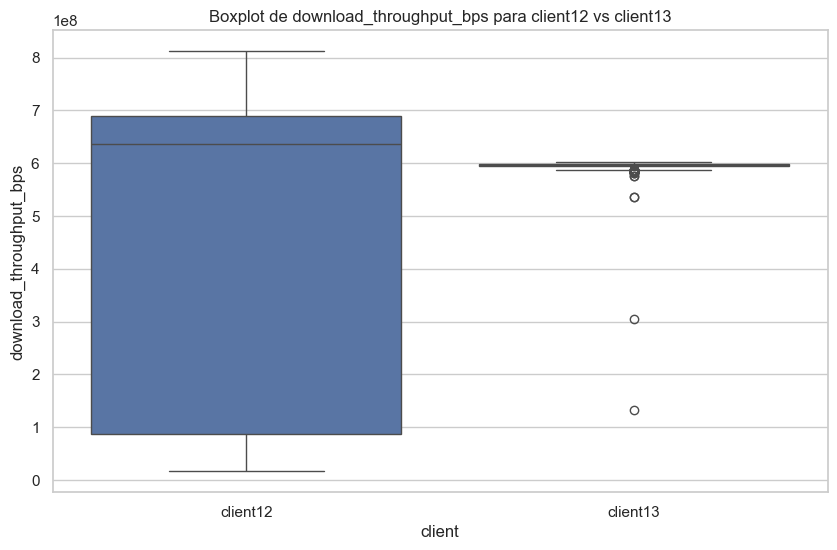

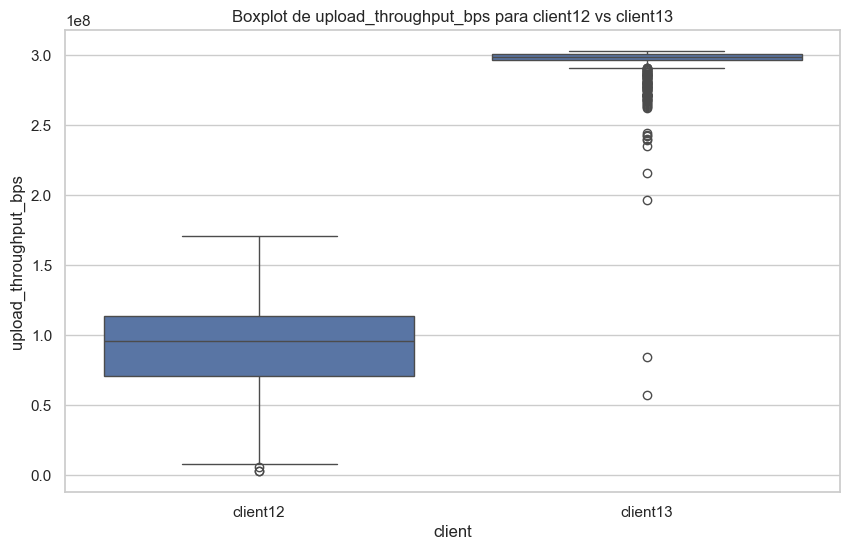

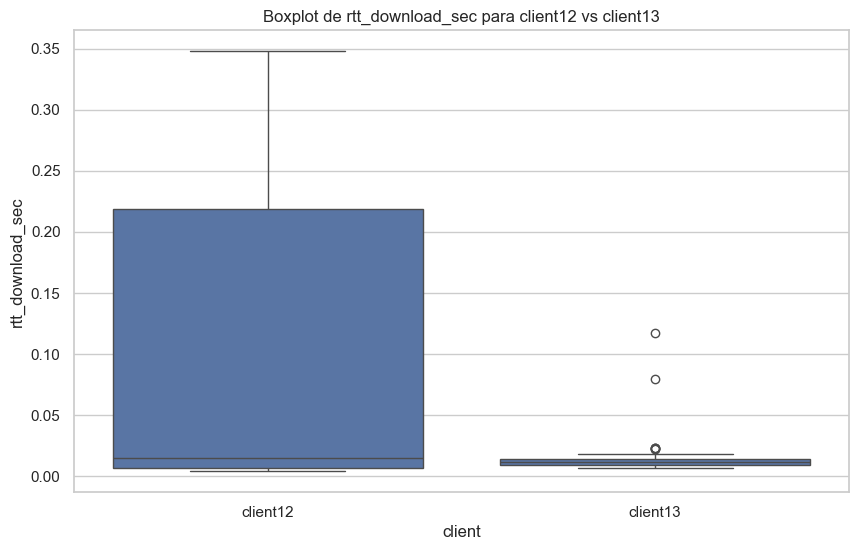

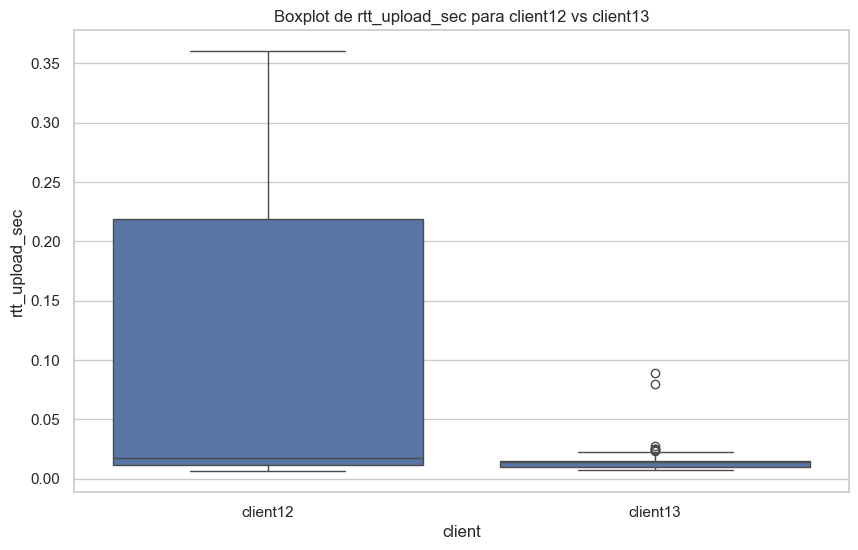

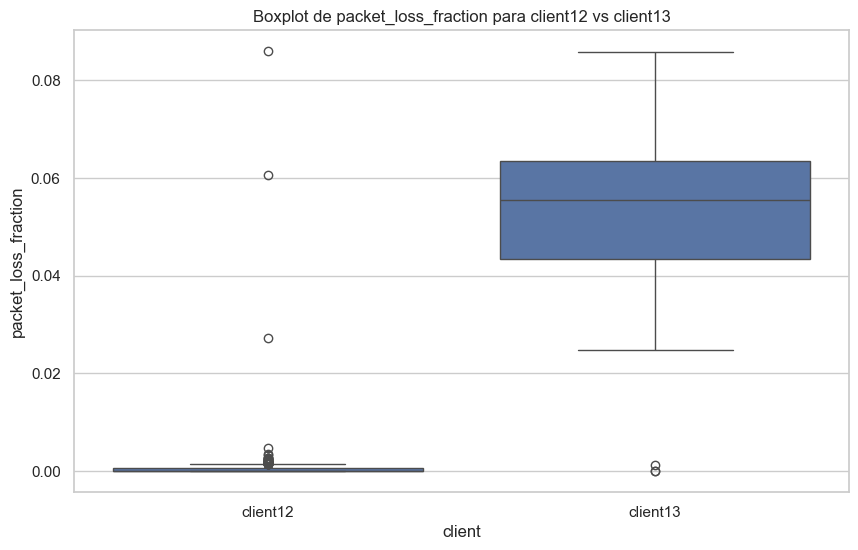

In [27]:
for var in variables_to_analyze:
    plt.figure(figsize=(10, 6))
    sns.boxplot(
        data=df_selected,
        x=entity_column,
        y=var
    )
    plt.title(f'Boxplot de {var} para {selected_entities[0]} vs {selected_entities[1]}')
    plt.show()

## 2.3 Scatter Plot (Correlação)

Vamos analisar a relação entre o RTT de download e o Throughput de download para os dois clientes.

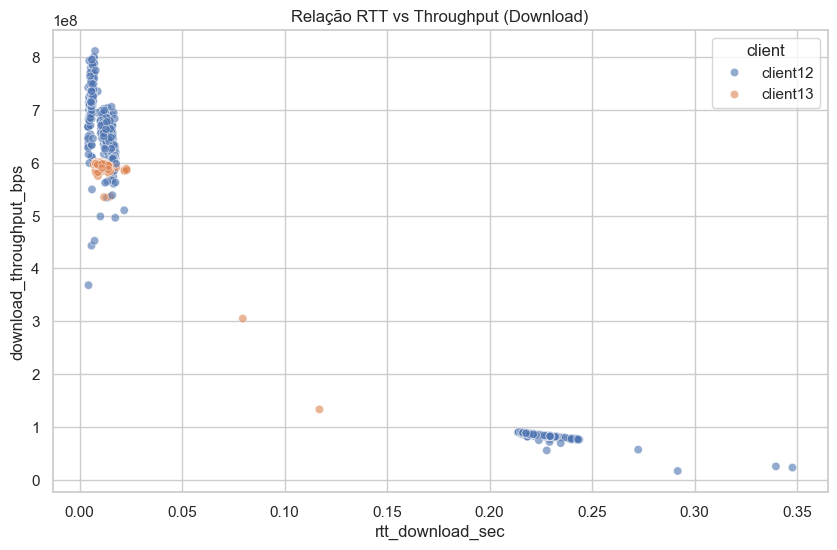

In [28]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_selected,
    x='rtt_download_sec',
    y='download_throughput_bps',
    hue=entity_column,
    alpha=0.6
)
plt.title('Relação RTT vs Throughput (Download)')
plt.show()

## Etapa 3: Definição dos Modelos Candidatos

A próxima etapa do projeto (3.1 no PDF) é, a partir dos gráficos acima, definir um modelo paramétrico candidato para cada variável.

Analisando os histogramas e as sugestões da Seção 4 do PDF, os modelos candidatos são:

1.  **RTT (up e down)**: A distribuição parece assimétrica, mas o PDF (Seção 4.1) sugere usar a **Distribuição Normal** (possivelmente pela facilidade da prior conjugada Normal-Normal).
2.  **Throughput (up e down)**: Os dados são estritamente positivos e assimétricos à direita. O modelo sugerido (Seção 4.3) é a **Distribuição Gama**.
3.  **Fração de Perda**: É uma proporção (0-1). O modelo sugerido (Seção 4.2) é o **Modelo Beta-Binomial** (usando a Binomial para a contagem de pacotes perdidos).

A Etapa 2 está concluída. Quando estiver pronto, passaremos para a **Etapa 4: Cálculo dos Estimadores MLE** para esses modelos.

# Etapa 4: Máxima Verossimilhança (MLE)

Iniciando a Fase 2 do projeto. [cite_start]Vamos usar o método da Máxima Verossimilhança (MLE) para estimar os parâmetros dos modelos definidos na Etapa 3[cite: 31].

[cite_start]Os parâmetros $\hat{\theta}_{MLE}$ calculados aqui (especialmente $\hat{\sigma}^2$ do RTT e $\hat{k}$ do Throughput) serão usados como valores "conhecidos" na Fase Bayesiana[cite: 61, 144].

In [46]:
from scipy.stats import norm, gamma
import warnings

warnings.filterwarnings('ignore', category=RuntimeWarning)

df_c12 = df_selected[df_selected['client'] == 'client12']
df_c13 = df_selected[df_selected['client'] == 'client13']

mle_params_c12 = {}
mle_params_c13 = {}

n_t_assumido = 1000

print(f"DataFrames separados para client12 ({df_c12.shape[0]} linhas) e client13 ({df_c13.shape[0]} linhas)")
print(f"Assumindo n_t = {n_t_assumido} pacotes por teste para o modelo Binomial")

DataFrames separados para client12 (640 linhas) e client13 (644 linhas)
Assumindo n_t = 1000 pacotes por teste para o modelo Binomial


## 4.1 Cálculo MLE para `client12`

In [47]:
mle_params_c12 = {}

mu_rtt_d_c12, std_rtt_d_c12 = norm.fit(df_c12['rtt_download_sec'])
mle_params_c12['rtt_download_sec'] = {'mu': mu_rtt_d_c12, 'std': std_rtt_d_c12, 'var': std_rtt_d_c12**2}

mu_rtt_u_c12, std_rtt_u_c12 = norm.fit(df_c12['rtt_upload_sec'])
mle_params_c12['rtt_upload_sec'] = {'mu': mu_rtt_u_c12, 'std': std_rtt_u_c12, 'var': std_rtt_u_c12**2}

shape_th_d_c12, _, scale_th_d_c12 = gamma.fit(df_c12['download_throughput_bps'], floc=0)
mle_params_c12['download_throughput_bps'] = {'shape_k': shape_th_d_c12, 'scale': scale_th_d_c12, 'rate_beta': 1/scale_th_d_c12}

shape_th_u_c12, _, scale_th_u_c12 = gamma.fit(df_c12['upload_throughput_bps'], floc=0)
mle_params_c12['upload_throughput_bps'] = {'shape_k': shape_th_u_c12, 'scale': scale_th_u_c12, 'rate_beta': 1/scale_th_u_c12}

x_tot_c12 = np.sum(df_c12['packet_loss_fraction'] * n_t_assumido)
n_tot_c12 = len(df_c12) * n_t_assumido
p_mle_c12 = x_tot_c12 / n_tot_c12
mle_params_c12['packet_loss_fraction'] = {'p_mle': p_mle_c12, 'x_tot': x_tot_c12, 'n_tot': n_tot_c12}

print("Cálculos MLE para client12 concluídos.")

Cálculos MLE para client12 concluídos.


## 4.1.1 Apresentação dos Resultados (client12)

In [48]:
df_mle_c12 = pd.DataFrame(mle_params_c12).T
print("--- Parâmetros MLE para client12 (Formatado) ---")
print(df_mle_c12)

--- Parâmetros MLE para client12 (Formatado) ---
                              mu      std      var  shape_k            scale  rate_beta    p_mle      x_tot         n_tot
rtt_download_sec        0.086485 0.103753 0.010765      NaN              NaN        NaN      NaN        NaN           NaN
rtt_upload_sec          0.073462 0.097222 0.009452      NaN              NaN        NaN      NaN        NaN           NaN
download_throughput_bps      NaN      NaN      NaN 1.484816 313012352.608103   0.000000      NaN        NaN           NaN
upload_throughput_bps        NaN      NaN      NaN 6.758103  13638616.904086   0.000000      NaN        NaN           NaN
packet_loss_fraction         NaN      NaN      NaN      NaN              NaN        NaN 0.000638 408.349586 640000.000000


## 4.2 Cálculo MLE para `client13`

In [49]:
mle_params_c13 = {}

mu_rtt_d_c13, std_rtt_d_c13 = norm.fit(df_c13['rtt_download_sec'])
mle_params_c13['rtt_download_sec'] = {'mu': mu_rtt_d_c13, 'std': std_rtt_d_c13, 'var': std_rtt_d_c13**2}

mu_rtt_u_c13, std_rtt_u_c13 = norm.fit(df_c13['rtt_upload_sec'])
mle_params_c13['rtt_upload_sec'] = {'mu': mu_rtt_u_c13, 'std': std_rtt_u_c13, 'var': std_rtt_u_c13**2}

shape_th_d_c13, _, scale_th_d_c13 = gamma.fit(df_c13['download_throughput_bps'], floc=0)
mle_params_c13['download_throughput_bps'] = {'shape_k': shape_th_d_c13, 'scale': scale_th_d_c13, 'rate_beta': 1/scale_th_d_c13}

shape_th_u_c13, _, scale_th_u_c13 = gamma.fit(df_c13['upload_throughput_bps'], floc=0)
mle_params_c13['upload_throughput_bps'] = {'shape_k': shape_th_u_c13, 'scale': scale_th_u_c13, 'rate_beta': 1/scale_th_u_c13}

x_tot_c13 = np.sum(df_c13['packet_loss_fraction'] * n_t_assumido)
n_tot_c13 = len(df_c13) * n_t_assumido
p_mle_c13 = x_tot_c13 / n_tot_c13
mle_params_c13['packet_loss_fraction'] = {'p_mle': p_mle_c13, 'x_tot': x_tot_c13, 'n_tot': n_tot_c13}

print("Cálculos MLE para client13 concluídos.")

Cálculos MLE para client13 concluídos.


## 4.2.1 Apresentação dos Resultados (client13)

In [50]:
df_mle_c13 = pd.DataFrame(mle_params_c13).T
print("--- Parâmetros MLE para client13 (Formatado) ---")
print(df_mle_c13)

--- Parâmetros MLE para client13 (Formatado) ---
                              mu      std      var    shape_k          scale  rate_beta    p_mle        x_tot         n_tot
rtt_download_sec        0.011748 0.005652 0.000032        NaN            NaN        NaN      NaN          NaN           NaN
rtt_upload_sec          0.012986 0.004991 0.000025        NaN            NaN        NaN      NaN          NaN           NaN
download_throughput_bps      NaN      NaN      NaN 348.781682 1702879.463415   0.000001      NaN          NaN           NaN
upload_throughput_bps        NaN      NaN      NaN 173.134749 1702515.217247   0.000001      NaN          NaN           NaN
packet_loss_fraction         NaN      NaN      NaN        NaN            NaN        NaN 0.053361 34364.480227 644000.000000


A Etapa 4 está concluída. Os parâmetros $\hat{\theta}_{MLE}$ estão armazenados e formatados.

A próxima etapa é a **Etapa 5: Avaliação do Ajuste (Fit) do MLE**, onde usaremos esses parâmetros para plotar as funções de densidade sobre os histogramas e criar os QQ plots, conforme solicitado na Seção 3.2 do PDF.

# Etapa 5: Avaliação do Ajuste (Fit) do MLE

Vamos agora diagnosticar a qualidade do ajuste dos nossos modelos. Para cada variável e cada cliente, faremos:
1.  Um gráfico do Histograma (dados reais) sobreposto com a PDF (função densidade) do modelo ajustado com os parâmetros MLE.
2.  Um QQ-Plot para comparar os quantis dos dados reais com os quantis teóricos do modelo.

In [80]:
import statsmodels.api as sm
from scipy.stats import norm, gamma
import scipy.stats as stats

def plot_mle_fit(data, model_type, params_dict, client_name, var_name):
    plt.figure(figsize=(14, 6))

    ax1 = plt.subplot(1, 2, 1)
    sns.histplot(data, kde=False, stat="density", label="Dados Reais", element="step", ax=ax1)

    xmin, xmax = ax1.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    
    prob_plotter = None

    if model_type == 'norm':
        mu = params_dict['mu']
        std = params_dict['std']
        pdf = norm.pdf(x, mu, std)
        ax1.plot(x, pdf, 'r-', lw=2, label=f'PDF Normal (μ={mu:.3f}, σ={std:.3f})')
        
        dist_obj = stats.norm(loc=mu, scale=std)
        prob_plotter = sm.ProbPlot(data, dist=dist_obj)

    elif model_type == 'gamma':
        k = params_dict['shape_k']
        scale = params_dict['scale']
        pdf = gamma.pdf(x, a=k, scale=scale, floc=0)
        ax1.plot(x, pdf, 'r-', lw=2, label=f'PDF Gama (k={k:.3f}, θ={scale:.3f})')
        
        dist_obj = stats.gamma(a=k, loc=0, scale=scale)
        prob_plotter = sm.ProbPlot(data, dist=dist_obj)

    elif model_type == 'binom':
        ax1.set_title(f'Modelo Binomial (p={params_dict["p_mle"]:.6f}) - Gráfico N/A')
        return

    ax1.set_title(f'Histograma vs PDF (MLE) - {client_name} - {var_name}')
    ax1.legend()

    ax2 = plt.subplot(1, 2, 2)
    if prob_plotter:
        prob_plotter.qqplot(line='s', ax=ax2)
    ax2.set_title(f'QQ Plot - {client_name} - {var_name}')

    plt.tight_layout()
    plt.show()

print("Função de plotagem 'plot_mle_fit' (corrigida) definida.")

Função de plotagem 'plot_mle_fit' (corrigida) definida.


## 5.1 Gráficos de Ajuste - client12

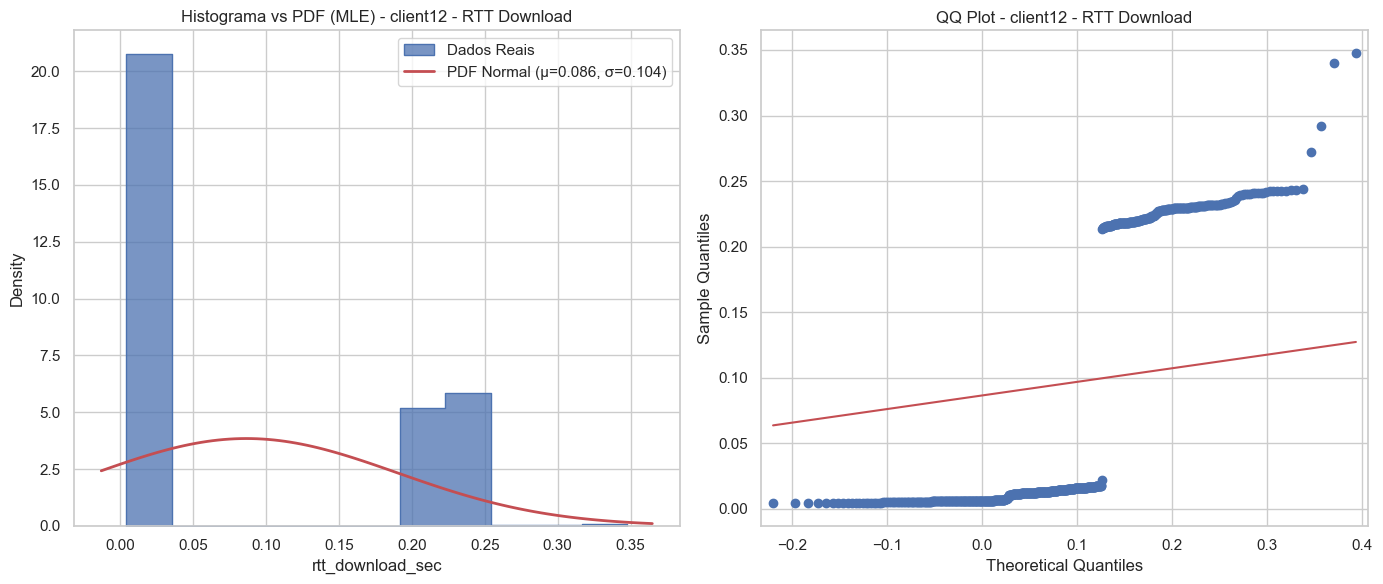

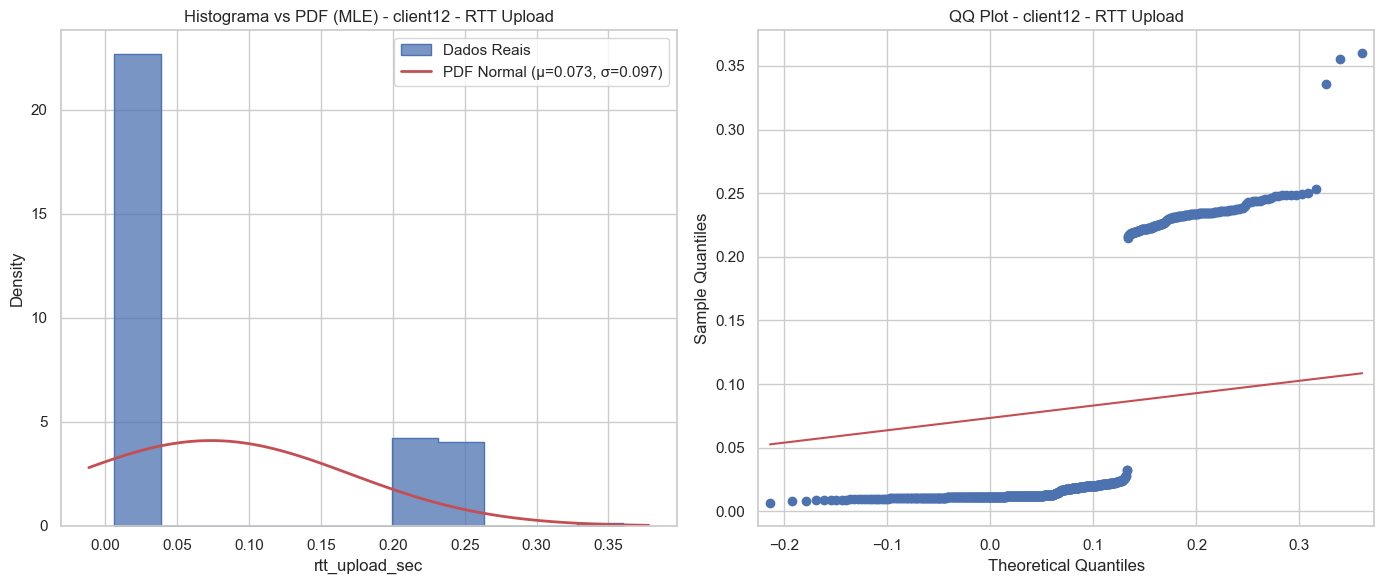

TypeError: _parse_args() got an unexpected keyword argument 'floc'. Did you mean 'loc'?

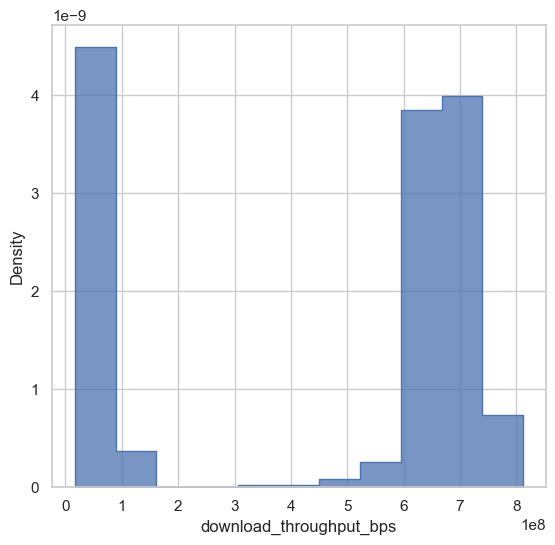

In [81]:
plot_mle_fit(df_c12['rtt_download_sec'], 'norm', mle_params_c12['rtt_download_sec'], 'client12', 'RTT Download')
plot_mle_fit(df_c12['rtt_upload_sec'], 'norm', mle_params_c12['rtt_upload_sec'], 'client12', 'RTT Upload')
plot_mle_fit(df_c12['download_throughput_bps'], 'gamma', mle_params_c12['download_throughput_bps'], 'client12', 'Throughput Download')
plot_mle_fit(df_c12['upload_throughput_bps'], 'gamma', mle_params_c12['upload_throughput_bps'], 'client12', 'Throughput Upload')

## 5.2 Gráficos de Ajuste - client13

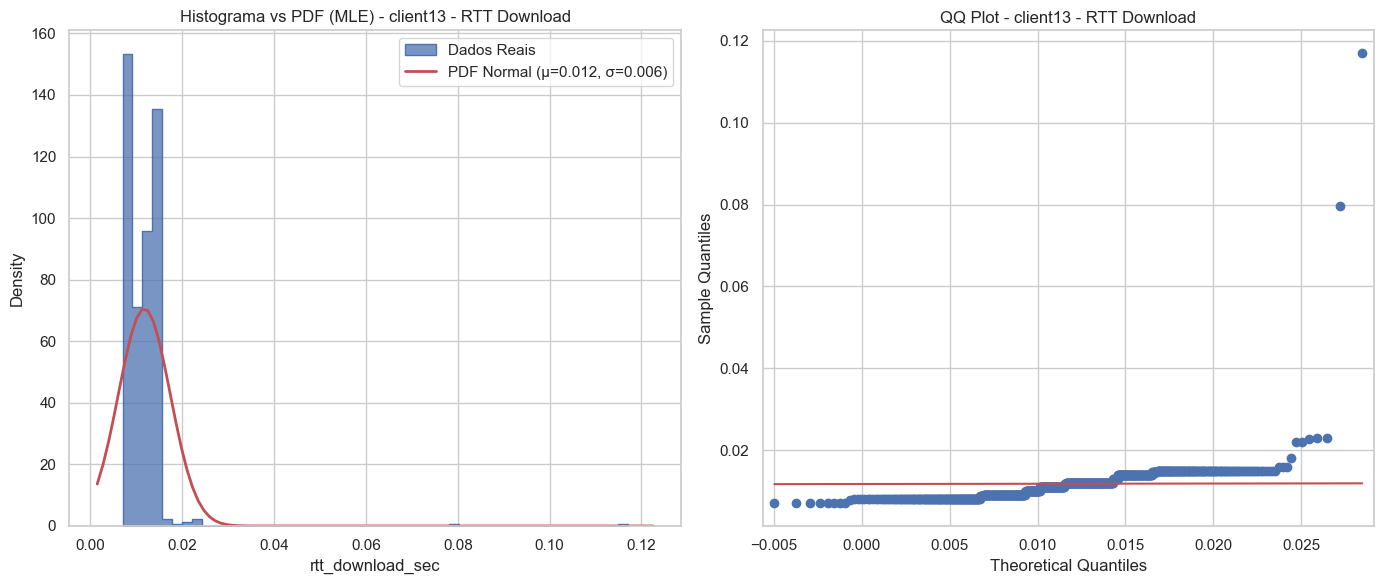

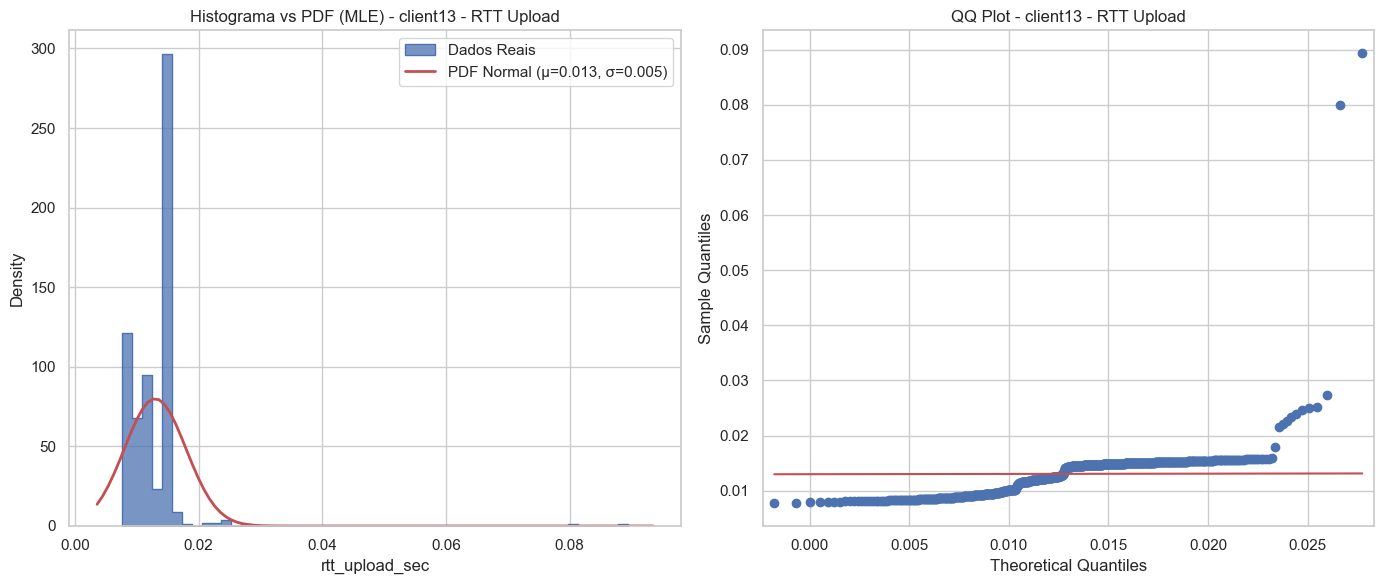

TypeError: _parse_args() got an unexpected keyword argument 'floc'. Did you mean 'loc'?

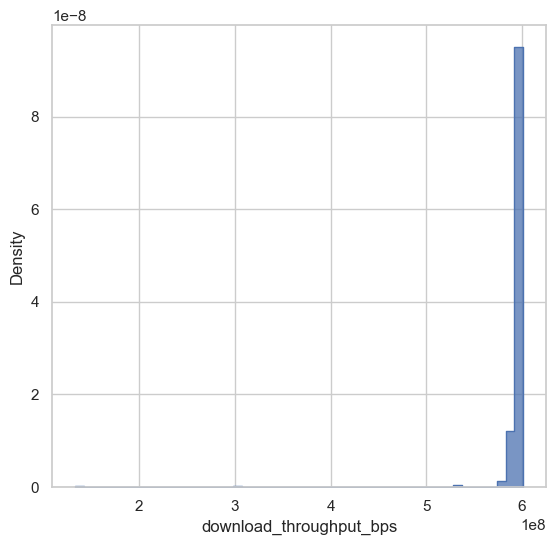

In [82]:
plot_mle_fit(df_c13['rtt_download_sec'], 'norm', mle_params_c13['rtt_download_sec'], 'client13', 'RTT Download')
plot_mle_fit(df_c13['rtt_upload_sec'], 'norm', mle_params_c13['rtt_upload_sec'], 'client13', 'RTT Upload')
plot_mle_fit(df_c13['download_throughput_bps'], 'gamma', mle_params_c13['download_throughput_bps'], 'client13', 'Throughput Download')
plot_mle_fit(df_c13['upload_throughput_bps'], 'gamma', mle_params_c13['upload_throughput_bps'], 'client13', 'Throughput Upload')

## Conclusão da Etapa 5

Os gráficos de diagnóstico (Histograma/PDF e QQ-Plots) estão concluídos.

**Próximo Passo:** Iniciar a Fase 3 (Inferência Bayesiana) com a **Etapa 6: Preparação Bayesiana (Split e Priors)**.